In [8]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots
import ProgressMeter: @showprogress

import Base: show
import PDMats: PDMat

In [13]:
function hgf(n, iters, data)
    model = Model(DefaultMessageGate())
    
    xt_min = add!(model, datavar(:xt_min, NormalMeanVariance{Float64}))
    xt     = add!(model, randomvar(:xt))
    
    zvar   = add!(model, constvar(:zvar, 0.05))
    zt_min = add!(model, datavar(:zt_min, NormalMeanVariance{Float64}))
    zt     = add!(model, randomvar(:zt))
    
    gaussian = make_node(NormalMeanVariance{Float64}, zt_min, zvar, zt)
    
    kt = add!(model, datavar(:kt, NormalMeanVariance{Float64}))
    ωt = add!(model, datavar(:wt, NormalMeanVariance{Float64}))
    
    gcv = add!(model, make_node(GCV, xt_min, zt, kt, ωt, xt))

    noise = add!(model, constvar(:noise, NormalMeanVariance(0.0, 20.0)))
    y     = add!(model, datavar(:y, Float64))
    
    add_noise = add!(model, make_node(+, xt, noise, y))
    
    activate!(model)
    
    # Prior marginals
    setmarginal!(gcv, :xy, MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat([ 5.0 0.0 ; 0.0 5.0 ])))
    setmarginal!(gcv, :z, NormalMeanVariance(0.0, 5.0))
    setmarginal!(gcv, :κ, NormalMeanVariance(1.0, 5.0))
    setmarginal!(gcv, :ω, NormalMeanVariance(0.0, 5.0))
    
    mk = Vector{NormalMeanVariance}()
    mw = Vector{NormalMeanVariance}()
    mz = Vector{NormalMeanVariance}()
    mx = Vector{NormalMeanVariance}()

    s_mk = subscribe!(getmarginal(kt), (t) -> push!(mk, getdata(t)))
    s_mw = subscribe!(getmarginal(ωt), (t) -> push!(mw, getdata(t)))
    s_mz = subscribe!(getmarginal(zt), (t) -> push!(mz, getdata(t)))
    s_mx = subscribe!(getmarginal(xt), (t) -> push!(mx, getdata(t)))
    
    # Initial messages
    current_zt = NormalMeanVariance(0.0, 5.0)
    current_kt = NormalMeanVariance(1.0, 5.0)
    current_ωt = NormalMeanVariance(0.0, 5.0)
    current_xt = NormalMeanVariance(0.0, 5.0)
    
    mk_out = Vector{NormalMeanVariance}(undef, n)
    mw_out = Vector{NormalMeanVariance}(undef, n)
    mz_out = Vector{NormalMeanVariance}(undef, n)
    mx_out = Vector{NormalMeanVariance}(undef, n)
    
    @showprogress for i in 1:n
        for _ in 1:iters
            update!(y, data[i])
            update!(zt_min, current_zt)
            update!(kt, current_kt)
            update!(ωt, current_ωt)
            update!(xt_min, current_xt)
        end
        
        current_zt = mz[end]
        current_kt = mk[end]
        current_ωt = mw[end]
        current_xt = mx[end]
        
        mk_out[i] = current_kt
        mw_out[i] = current_ωt
        mz_out[i] = current_zt
        mx_out[i] = current_xt
    end
    
    unsubscribe!(s_mk)
    unsubscribe!(s_mw)
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    
    return mx_out, mk_out, mw_out, mz_out
end

hgf (generic function with 1 method)

In [16]:
n = 1000
iters = 20

real_k = 1.0
real_w = 0.0

z_prev     = 0.0
z_variance = 0.05

z = Vector{Float64}(undef, n)
for i in 1:n
    z[i] = rand(Normal(z_prev, z_variance))
    z_prev = z[i]
end

v = map(d -> exp(real_k * d + real_w), z)
y = Vector{Float64}(undef, n)

y_prev = 0.0

for i in 1:n
    y[i] = rand(Normal(y_prev, v[i]))
    y_prev = y[i]
end

obs_noise = 20.0

data = map(d -> d + rand(Normal(0, sqrt(obs_noise))), y);

In [17]:
@time mx, mk, mw, mz = hgf(n, iters, data);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.696202 seconds (8.06 M allocations: 501.189 MiB, 15.15% gc time)


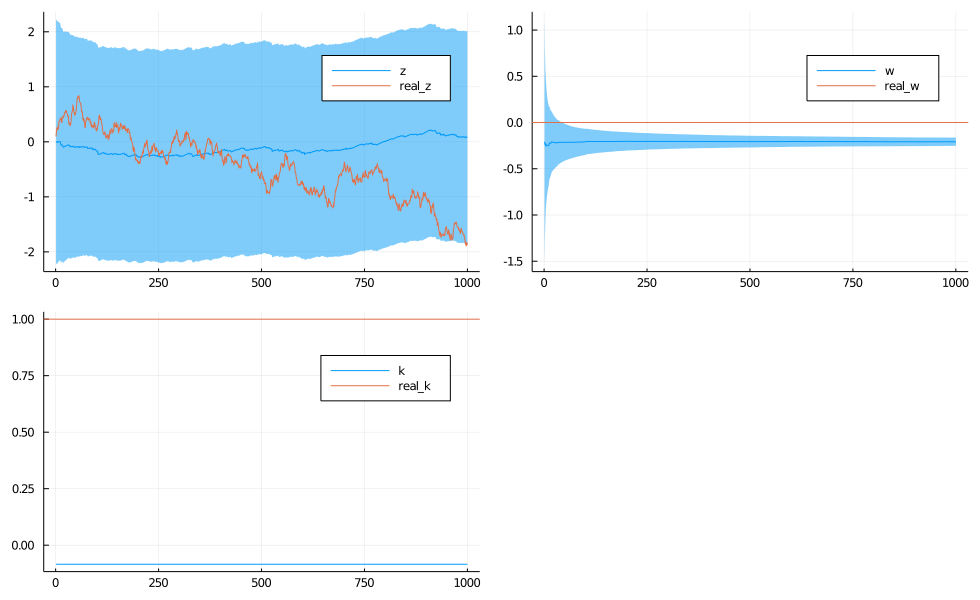

In [6]:
plot(mean.(mz), ribbon = std.(mz), label = :z)
p1 = plot!(z, label = :real_z)

plot(mean.(mw), ribbon = std.(mw), label = :w)
p2 = plot!([ real_w ], seriestype=:hline, label = :real_w)

plot(mean.(mk), ribbon = std.(mk), label = :k)
p3 = plot!([ real_k ], seriestype=:hline, label = :real_k)

plot(p1, p2, p3, size = (980, 600))

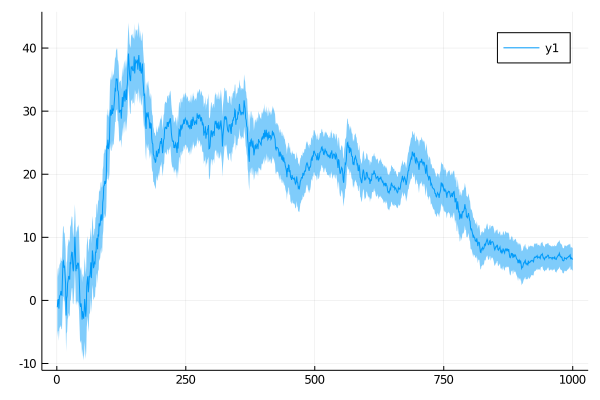

In [7]:
#plot(mean.(mx), ribbon = std.(mx))
#scatter!(data, alpha = 0.2)
# scatter!(y)
plot(y, ribbon = sqrt.(exp.(1.0.*z .+ 3.0)))
# scatter!(data, alpha = 0.3)